In [1]:
import os
import re
import pandas as pd
from osgeo import gdal
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
gdal.UseExceptions()

In [2]:
BUCKET = '1182020'
COLLECTION = 'MODIS_land_cover'
EXPORT_PATH = './output/'

In [29]:
# copy metadata from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/metadata/{COLLECTION} ./metadata

In [13]:
# copy images from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/images_tif/{COLLECTION} ./images_tif

  platform                   country                   country_clean  \
0   afr100                     Benin                           Benin   
1   afr100              Burkina Faso                    Burkina Faso   
2   afr100                   Burundi                         Burundi   
3   afr100                  Cameroon                        Cameroon   
4   afr100  Central African Republic  Central African Republic (the)   

  alpha2code alpha3code  numeric  area_km2  
0         BJ        BEN      204  114763.0  
1         BF        BFA      854  270764.0  
2         BI        BDI      108   27834.0  
3         CM        CMR      120  476350.0  
4         CF        CAF      140  622436.0  


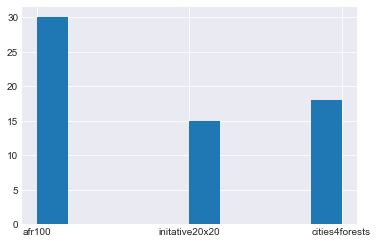

In [199]:
# get countries that have metadata in path (images should be there if metadata is)
p = re.compile('[A-Z]{3}')
countries = [country.replace('.csv', '') for country in os.listdir(F'./metadata/{COLLECTION}') if p.match(country)]

def get_platform_countries():
    areas_by_platform = pd.read_csv('./platforms/areas_served_by_platform.csv')
    country_codes = pd.read_csv('./platforms/country_codes.csv').rename(columns={'country': 'country_clean'})
    countries = areas_by_platform[['platform', 'country', 'country_clean']].drop_duplicates()
    countries = countries.merge(country_codes, how='left', on=['country_clean'])
    # add country area info
    country_areas = pd.read_csv('./platforms/country_areas.csv')[['country_clean', 'area_km2']]
    countries = countries.merge(country_areas, how='left', on=['country_clean'])
    return countries

# histogram of countries with collection data, by platform
countries_platforms_all = get_platform_countries()
countries_platforms = countries_platforms_all[countries_platforms_all['alpha3code'].isin(countries)]
print(countries_platforms.head())
plt.hist(countries_platforms['platform'])
plt.show()

In [4]:
def process_images(country):
    metadata = pd.read_csv(F'./metadata/{COLLECTION}/{country}.csv')
    # dict for dates
    img_ts_dict = dict(zip(metadata['image_id'], metadata['image_timestamp']))
    image_ids = metadata['image_id']
    image_fps = [F'./images_tif/{COLLECTION}/{country}/{image_id.replace("/", "-")}.tif' for image_id in image_ids]
    images = [gdal.Open(image_fp).ReadAsArray() for image_fp in image_fps]
    return images, image_ids, img_ts_dict

In [5]:
countries = countries_platforms['alpha3code'].unique()
country = countries[0]
images, image_ids, img_ts_dict = process_images(country)

In [100]:
# check first image of test country
ds = gdal.Open(F'./images_tif/{COLLECTION}/{country}/{image_ids[0].replace("/", "-")}.tif')
print(ds.GetProjection())
print(ds.GetGeoTransform())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(19.295812302887324, 0.008983152841195215, 0.0, 42.69692545420086, 0.0, -0.008983152841195215)


In [10]:
images[0].shape

(13, 680, 338)

In [19]:
def plot_band(img, nband, country):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    im = ax.imshow(img[nband,:,:])
    ax.axis('off')
    ax.set_title(F"{country}: Band {nband}")
    fig.colorbar(im, ax=ax)
        
def plot_bands(img, country):
    # care about bands LC_Type1-5
    bands = range(5)
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    for band, ax in zip(bands, axs):
        im = ax.imshow(img[band,:,:])
        ax.axis('off')
        ax.set_title(F"{country}: Band LC_Type{band+1}")
        fig.colorbar(im, ax=ax)

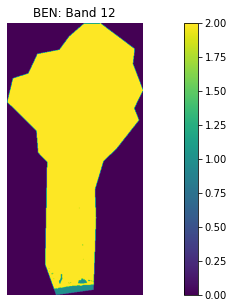

In [22]:
plot_band(images[0], 12, country)

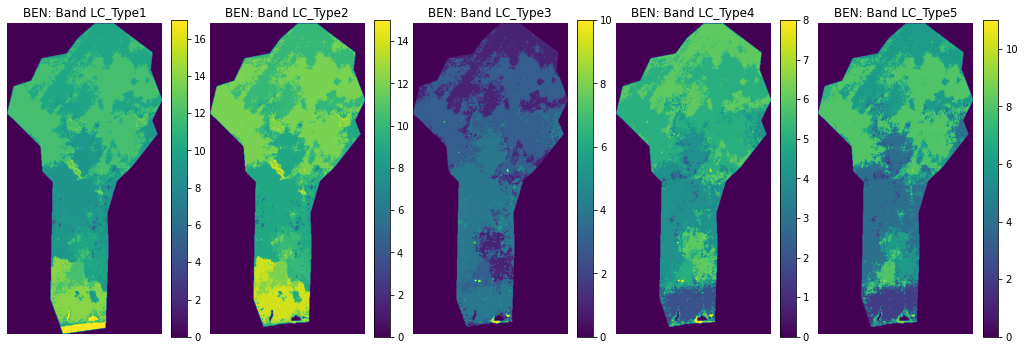

In [18]:
plot_bands(images[1], country)

In [25]:
def pixel_value_counts(img, img_ts, country):
    # annual images
    year = pd.to_datetime(img_ts).year
    # care about bands LC_Type1-5 and LW
    bands = list(range(5)) + [12]
    dfs = []
    for band in bands:
        img_1d = img[band,:,:].flatten()
        unique, counts = np.unique(img_1d, return_counts=True)
        df = pd.DataFrame({'value': unique, 'count': counts})
        df['alpha3code'] = country
        df['year'] = year
        if band <= 4:
            df['band'] = F'LC_Type{band+1}'
        elif band == 12:
            df['band'] = 'LW'
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def all_pixel_value_counts(countries, collection):
    all_dfs = []
    for country in tqdm(countries, total=len(countries), desc='Getting pixel value counts...'):
        images, image_ids, img_ts_dict = process_images(country)
        img_dfs = []
        for img, img_id in zip(images, image_ids):
            img_df = pixel_value_counts(img, img_ts_dict[img_id], country)
            img_dfs.append(img_df)
        all_img_dfs = pd.concat(img_dfs)
        all_dfs.append(all_img_dfs)
    all_dfs = pd.concat(all_dfs)
    return all_dfs

In [82]:
df = all_pixel_value_counts(countries, COLLECTION)
# merge with platform info
df = countries_platforms.merge(df, how='right', on=['alpha3code'])
# merge with band info
band_info = pd.read_csv('MODIS_land_cover_bands.csv')
df = band_info.merge(df, how='right', on=['band', 'value'])
os.makedirs(EXPORT_PATH, exist_ok=True)
df.to_csv(F'{EXPORT_PATH}{COLLECTION}.csv', index=False)

Getting pixel value counts...: 100%|██████████| 53/53 [03:18<00:00,  3.74s/it]


In [83]:
df.head()

,value,color,description,category,band,product,platform,country,alpha3code,count,year
0,0,NaN,NaN,NaN,LC_Type1,NaN,afr100,Benin,BEN,109408,2001
1,0,NaN,NaN,NaN,LC_Type1,NaN,afr100,Benin,BEN,109408,2002
2,0,NaN,NaN,NaN,LC_Type1,NaN,afr100,Benin,BEN,109408,2003
3,0,NaN,NaN,NaN,LC_Type1,NaN,afr100,Benin,BEN,109408,2004
4,0,NaN,NaN,NaN,LC_Type1,NaN,afr100,Benin,BEN,109408,2005


In [84]:
def land_use_percent(countries, band_name, EXPORT_PATH, COLLECTION):
    df = pd.read_csv(F'{EXPORT_PATH}{COLLECTION}.csv')
    # LC_Type 1 for now
    df = df[df['band'] == band_name]
    years = df['year'].unique()
    country_year_dfs = []
    for country in tqdm(countries, total=len(countries), desc=F'Getting land class by percent {band_name}...'):
        country_df = df[df['alpha3code'] == country]
        country_long = country_df['country'].iloc[0]
        platforms = country_df['platform'].unique()
        year_dfs = []
        for year in years:
            year_df = country_df[country_df['year'] == year]
            class_totals = year_df.groupby('category')['count'].sum().reset_index()
            total = class_totals['count'].sum()
            class_totals['category_percent'] = (class_totals['count']/total)*100
            class_totals['year'] = year
            class_totals['alpha3code'] = country
            class_totals['country'] = country_long
            class_totals['platform_1'] = platforms[0]
            if len(platforms) == 2:
                class_totals['platform_2'] = platforms[1]
            country_year_dfs.append(class_totals)
    land_use_percent_dfs = pd.concat(country_year_dfs).drop(columns=['count'])
    return land_use_percent_dfs

In [85]:
band_names = ['LC_Type1', 'LC_Type2', 'LW']
for band_name in band_names:
    df = land_use_percent(countries, band_name, EXPORT_PATH, COLLECTION)
    df.to_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}.csv', index=False)

Getting land class by percent LW...: 100%|██████████| 53/53 [00:03<00:00, 13.34it/s]


In [290]:
def plot_land_class_by_country(country, band_name, EXPORT_PATH, COLLECTION):
    df = pd.read_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}.csv')
    df = df[df['alpha3code'] == country][['year', 'category_percent', 'category']]
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    num=0
    for column in df['category'].unique():
#     for column in ['forest', 'cropland']:
        num+=1
        df_ = df[df['category'] == column]
        plt.plot(df_['year'], df_['category_percent'], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
    
    plt.legend(loc=2, ncol=2)
    plt.title(F"{country}", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Year")
    plt.ylabel("Land Class Percentage [%]")

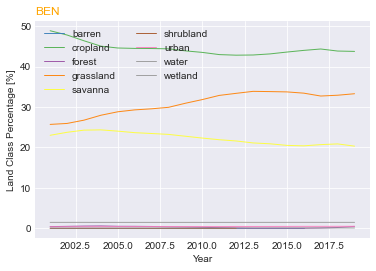

In [174]:
plot_land_class_by_country(countries[0], 'LC_Type1', EXPORT_PATH, COLLECTION)

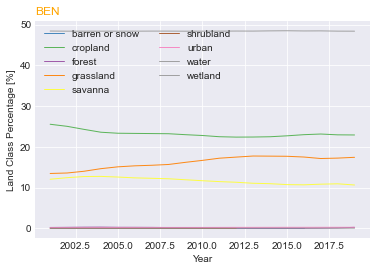

In [175]:
plot_land_class_by_country(countries[0], 'LC_Type2', EXPORT_PATH, COLLECTION)

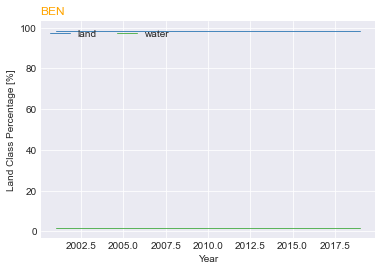

In [173]:
plot_land_class_by_country(countries[0], 'LW', EXPORT_PATH, COLLECTION)

In [289]:
# time series of land class % over years, for a country
# time series of land class % over years, for a platform
# decide which band to use for viz --> most relevant categories LC_Type1 and LC_Type2
# trends similar for LC_Type1 and LC_Type2, but LC_Type2 seems to misclassify water --> using LC_Type1 

In [284]:
def land_use_percent_by_platform(platform, band_name, countries_platforms, EXPORT_PATH, COLLECTION):
    df = pd.read_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}.csv')
    # add country area
    df = df.merge(countries_platforms[['alpha3code', 'area_km2']], how='left', on=['alpha3code'])
    platform_df = df[(df['platform_1'] == platform) | (df['platform_2'] == platform)]
    # platform stats, n countries and total area
    ncountries = platform_df['country'].nunique()
    total_area = platform_df[['alpha3code', 'area_km2']].drop_duplicates()['area_km2'].sum()
    print(F"Platform {platform}: area {total_area} km^2, {ncountries} countries in sample")
    # add platform percents
    platform_df['category_km2'] = round((platform_df['category_percent'] * platform_df['area_km2'])/100, 2)
    years = df['year'].unique()
    year_dfs = []
    for year in years:
        year_df = platform_df[platform_df['year'] == year].drop_duplicates()
        class_totals_area = year_df.groupby('category')['category_km2'].sum().reset_index()
        # make sure things add up
        annual_area_sum = class_totals_area['category_km2'].sum()
        assert abs(annual_area_sum - total_area) <= 5, 'Something wrong with totals'
        
        class_totals_area['platform_category_percent'] = (class_totals_area['category_km2']/total_area)*100
        class_totals_area['year'] = year
        class_totals_area['platform'] = platform
        class_totals_area['platform_km2'] = total_area
        class_totals_area['n_countries'] = ncountries
        year_dfs.append(class_totals_area)
    df = pd.concat(year_dfs)
    df.to_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}_{platform}.csv', index=False)

In [288]:
land_use_percent_by_platform('afr100', 'LC_Type1', countries_platforms, EXPORT_PATH, COLLECTION)
land_use_percent_by_platform('cities4forests', 'LC_Type1', countries_platforms, EXPORT_PATH, COLLECTION)
land_use_percent_by_platform('initative20x20', 'LC_Type1', countries_platforms, EXPORT_PATH, COLLECTION)

Platform afr100: area 17996906.0 km^2, 30 countries in sample
Platform cities4forests: area 19122827.0 km^2, 18 countries in sample


<ipython-input-284-009791bc7e18>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platform_df['category_km2'] = round((platform_df['category_percent'] * platform_df['area_km2'])/100, 2)
<ipython-input-284-009791bc7e18>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platform_df['category_km2'] = round((platform_df['category_percent'] * platform_df['area_km2'])/100, 2)


Platform initative20x20: area 14315734.0 km^2, 15 countries in sample


<ipython-input-284-009791bc7e18>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platform_df['category_km2'] = round((platform_df['category_percent'] * platform_df['area_km2'])/100, 2)


In [317]:
def compare_platform_land_class(category, band_name, EXPORT_PATH, COLLECTION):
    platforms = ['afr100', 'cities4forests', 'initative20x20']
    
    def platform_category(platform, category):
        df = pd.read_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}_{platform}.csv')
        df = df[df['category'] == category]
        df[platform] = df['platform_category_percent']
        return df[[platform, 'year']]
    
    dfs = [platform_category(platform, category) for platform in platforms]
    from functools import reduce
    df = reduce(lambda left,right: pd.merge(left,right,on='year'), dfs)
    
    print(df)
    # https://python-graph-gallery.com/125-small-multiples-for-line-chart/
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    
    num=0
    for column in platforms:
        num+=1
        # Find the right spot on the plot
        plt.subplot(1,3, num)
        # plot every groups, but discreet
        for v in platforms:
            plt.plot(df['year'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
            
        # Plot the lineplot
        plt.plot(df['year'], df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)

#         Same limits for everybody!
        plt.xlim(0,100)
        plt.ylim(0,100)

        # Not ticks everywhere
        if num in range(7) :
            plt.tick_params(labelbottom='off')
        if num not in [1,4,7] :
            plt.tick_params(labelleft='off')

        # Add title
        plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
    
    plt.suptitle(F"Land Cover Type: {category}", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
    
    plt.text(0.5, 0.02, 'Year', ha='center', va='center')
    plt.text(0.06, 0.5, 'Land Cover Type Percentage [%]', ha='center', va='center', rotation='vertical')

       afr100  year  cities4forests  initative20x20
0   13.193597  2001       27.185628       39.789600
1   13.236398  2002       27.141041       39.717916
2   13.263095  2003       26.988855       39.456724
3   13.295746  2004       26.897325       39.290280
4   13.295579  2005       26.753234       39.046242
5   13.263019  2006       26.613231       38.799450
6   13.266091  2007       26.507806       38.611626
7   13.236794  2008       26.426695       38.462106
8   13.229408  2009       26.372937       38.291849
9   13.250670  2010       26.300956       38.137507
10  13.238997  2011       26.206544       38.001164
11  13.160325  2012       26.101270       37.859318
12  13.089702  2013       26.100558       37.830762
13  13.061920  2014       26.084436       37.818849
14  13.042692  2015       26.050379       37.795689
15  13.016555  2016       25.954669       37.674182
16  12.942571  2017       26.011224       37.782662
17  12.869188  2018       25.906142       37.664962
18  12.86070

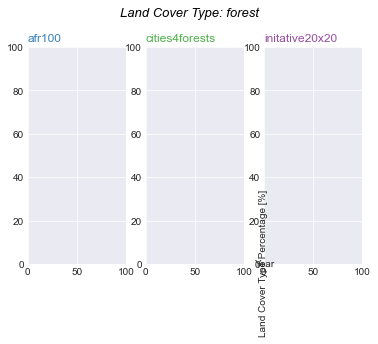

In [320]:
compare_platform_land_class('forest', 'LC_Type1', EXPORT_PATH, COLLECTION)

In [348]:
def compare_platform_land_class(category, band_name, EXPORT_PATH, COLLECTION):
    platforms = ['afr100', 'cities4forests', 'initative20x20']
    
    def platform_category(platform, category):
        df = pd.read_csv(F'{EXPORT_PATH}{COLLECTION}_percent_{band_name}_{platform}.csv')
        df = df[df['category'] == category]
        return df[['year', 'platform', 'platform_category_percent']]
    
    dfs = [platform_category(platform, category) for platform in platforms]
    df = pd.concat(dfs).rename(columns={'platform_category_percent': 'Land Cover Type Percentage [%]'})
    
    # https://python-graph-gallery.com/242-area-chart-and-faceting/
    import seaborn as sns
    # Create a grid : initialize it
    g = sns.FacetGrid(df, col='platform', hue='platform', col_wrap=4, )

    # Add the line over the area with the plot function
    g = g.map(plt.plot, 'year', 'Land Cover Type Percentage [%]')

    # Fill the area with fill_between
    g = g.map(plt.fill_between, 'year', 'Land Cover Type Percentage [%]', alpha=0.2).set_titles("{col_name} platform")

    # Control the title of each facet
    g = g.set_titles("{col_name}")

    # Add a title for the whole plot
    plt.subplots_adjust(left=0.2, top=0.8)
    g = g.fig.suptitle(F'Change in Land Cover Type: {category}')

    plt.show()


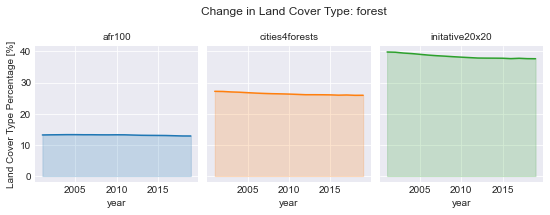

In [350]:
compare_platform_land_class('forest', 'LC_Type1', EXPORT_PATH, COLLECTION)

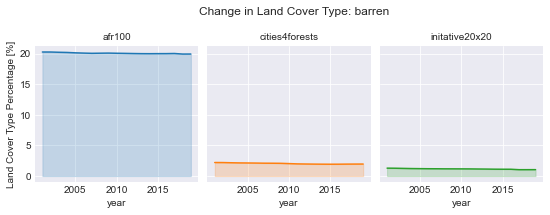

In [351]:
compare_platform_land_class('barren', 'LC_Type1', EXPORT_PATH, COLLECTION)

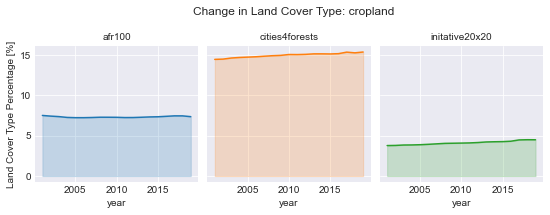

In [352]:
compare_platform_land_class('cropland', 'LC_Type1', EXPORT_PATH, COLLECTION)

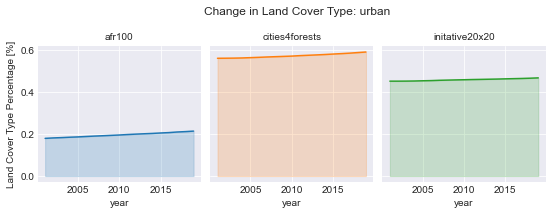

In [353]:
compare_platform_land_class('urban', 'LC_Type1', EXPORT_PATH, COLLECTION)

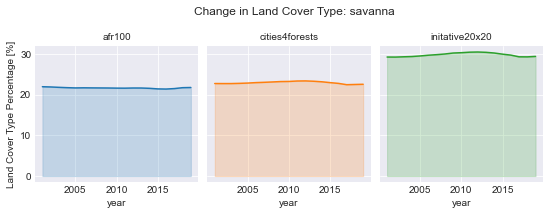

In [355]:
compare_platform_land_class('savanna', 'LC_Type1', EXPORT_PATH, COLLECTION)